# Lorenz84 Generation Acceleration

#### Created by Group B (PYNQ IMAGEINE): cakeforcat, Kandor9178 & sark02    (Github usernames)

Purpose: <br>Submission for University of Strathclyde course: EE315 Further VHDL and FPGA Design <br>

Aim: <br> To accelerate the process of generating strange attractors by passing off computationally challenging parts of the process to the programmable logic (PL) section of the PYNQ-Z2 device to quickly process them in parallel. The attractors generated using PL should be the same as those generated in PS <br>

Description: <br> This files contains the software and hardware implementation of the velocity Verlet method to generate data points for the 3D lorenz84 strange attractor. The two methods (PS and PS+PL) are timed to compare the generation process, to prove that using the combination of PL and PS can generate the coordinates faster than PS along, due to the parallel nature of PL <br>

### Software implementation:
##### Include relevant libraries:
matplotlib and mpl_toolkits for plotting image <br>
time to record elapsed time of processes <br>
numpy to create arrays

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

### Sim constants/parameters

In [2]:
# sim parameters
dt = 0.01
iterations = 30000#

### Software Implementation
#### Generate the derivative functions for Aizawa:

In [3]:
# initialize arrays to store trajectory
x = np.zeros(iterations)
y = np.zeros(iterations)
z = np.zeros(iterations)

x[0] = -0.2
y[0] = -2.82
z[0] = 2.71

# define lorenz84 attractor
def lorenz84_attractor(x, y, z):
    x_dot = -1*(0.95 * x) -(y ** 2) - (z ** 2) + 0.95 * 4.83
    y_dot = -y + (x * y) - (7.91 * x * z) + 4.66
    z_dot = -z + (7.91 * x * y) + (x * z)
    return x_dot, y_dot, z_dot

def velocity_verlet(x0, y0, z0):
    x = np.zeros(iterations)
    y = np.zeros(iterations)
    z = np.zeros(iterations)
    x[0] = x0
    y[0] = y0
    z[0] = z0

    for i in range(1, iterations):
        x_dot, y_dot, z_dot = lorenz84_attractor(x[i-1], y[i-1], z[i-1])
        x[i] = x[i-1] + x_dot * dt + 0.5 * x_dot * dt**2
        y[i] = y[i-1] + y_dot * dt + 0.5 * y_dot * dt**2
        z[i] = z[i-1] + z_dot * dt + 0.5 * z_dot * dt**2

        x_dot_new, y_dot_new, z_dot_new = lorenz84_attractor(x[i], y[i], z[i])
        x[i] += 0.5 * x_dot_new * dt**2
        y[i] += 0.5 * y_dot_new * dt**2
        z[i] += 0.5 * z_dot_new * dt**2
    return x, y, z

#### Generate coordinates of Aizawa using velocity Verlet:

In [4]:
start = time.time()
# Velocity Verlet integration
x, y, z = velocity_verlet(x[0], y[0], z[0])

elapsed_software_time = time.time() - start
print("Time to generate coordinates from software = ", elapsed_software_time, " seconds")
print("Average time to find next point =", elapsed_software_time/iterations, " seconds")

Time to generate coordinates from software =  3.872363805770874  seconds
Average time to find next point = 0.0001290787935256958  seconds


#### Plot software results:

<IPython.core.display.Javascript object>


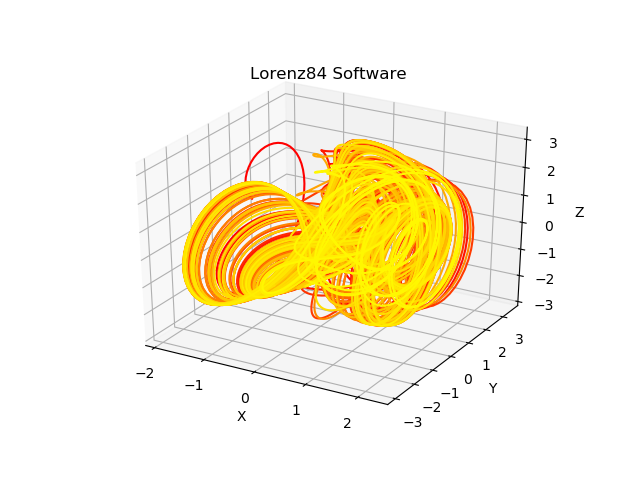

Time to plot points =  1.754138708114624  seconds


In [5]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
steps = int(iterations/1000)
iterationNew = int(iterations/steps)
plotXSoft=[]
plotXSoft = [0 for i in range(iterationNew)]
plotYSoft=[]
plotYSoft = [0 for i in range(iterationNew)]
plotZSoft=[]
plotZSoft = [0 for i in range(iterationNew)]
for j in range(0,steps):
    color = plt.cm.autumn(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=color)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Lorenz84 Software")
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

### Hardware implementation:
#### Import Aizawa hardware:

#### Import Aizawa hardware:

In [6]:
from pynq import Overlay
#from pynq import DefaultIP
ol = Overlay("lorenz84Ver.bit")
ol?
lorenz84_ip= ol.lorenz84_hardware_0


#### Hardware Driver

In [7]:
def lorenz84Deriv(xBin, yBin, zBin):
    lorenz84_ip.write(0x08, xBin)
    lorenz84_ip.write(0x04, yBin)
    lorenz84_ip.write(0x00, zBin)
    return lorenz84_ip.read(0x0C), lorenz84_ip.read(0x10), lorenz84_ip.read(0x14)

#### Create binary to float conversion:
Communication between software and hardware transfers 32 bits at a time; to allow for correct range and precision of expected results 8 integer bits were transferred and 24 fractional bits and is a signed number. When recieved, this binary formatting needs to be scaled back to float for plotting.

In [8]:
def binary_to_float(val):
    return float(val-(2**32)*int(str((val)>>(32-1))))/(2**24)

def float_to_binary(val):
    output = val*2**24
    if (output <0):
        output = int(int(output)+int(2**32))
    return int(output)

#### Generate results from hardware:

In [9]:
xBin = []
yBin = []
zBin = []

xBin = [0 for i in range(iterations)]
yBin = [0 for i in range(iterations)]
zBin = [0 for i in range(iterations)]

xBin[0] = (float_to_binary(1))
yBin[0] = (float_to_binary(1))
zBin[0] = (float_to_binary(1))


xvalshw = []
yvalshw = []
zvalshw = []

start = time.time()

for i in range(1,iterations):
    xBin[i], yBin[i], zBin[i] = lorenz84Deriv(xBin[i-1],yBin[i-1],zBin[i-1])

elapsed_hardware_time = time.time() - start
print("Time to generate coordinates from hardware = ", elapsed_hardware_time, " seconds")

#Convert numbers to float from binary format
for i in range(iterations):
    xvalshw.append(binary_to_float(xBin[i]))
    yvalshw.append(binary_to_float(yBin[i]))
    zvalshw.append(binary_to_float(zBin[i]))
print("Total time including conversion to float format in software = " , time.time()-start, " seconds")
diff = 0
for i in range(iterations):
    diff = abs(x[i]+y[i]+z[i]) - (xvalshw[i]+yvalshw[i]+zvalshw[i])
print('average difference = ',diff/iterations)

Time to generate coordinates from hardware =  5.000933647155762  seconds
Total time including conversion to float format in software =  6.755926847457886  seconds
average difference =  0.00014665797393781705


##### Plot hardware results:

<IPython.core.display.Javascript object>


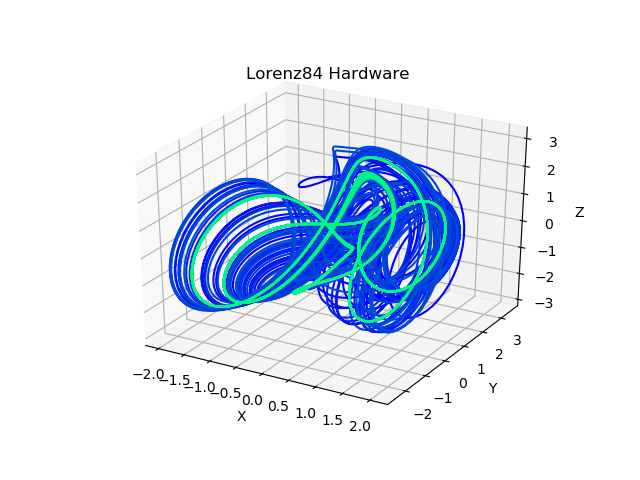

Time to plot points =  1.466756820678711  seconds


In [10]:
start = time.time()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plotXHard=[]
plotXHard = [0 for i in range(iterationNew)]
plotYHard=[]
plotYHard = [0 for i in range(iterationNew)]
plotZHard=[]
plotZHard = [0 for i in range(iterationNew)]
for j in range(0,steps):
    colorHard = plt.cm.winter(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXHard[i] = xvalshw[j*iterationNew + i-1]
            plotYHard[i] = yvalshw[j*iterationNew + i-1]
            plotZHard[i] = zvalshw[j*iterationNew + i-1]
        else:    
            plotXHard[i] = xvalshw[j*iterationNew + i]
            plotYHard[i] = yvalshw[j*iterationNew + i]
            plotZHard[i] = zvalshw[j*iterationNew + i]
    ax.plot3D(plotXHard, plotYHard, plotZHard, color=colorHard)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz84 Hardware')
plt.show()

elapsed_time = time.time() - start
print("Time to plot points = ", elapsed_time, " seconds" )

### Comparison of Two Methods:
##### Graphical Comparison:

<IPython.core.display.Javascript object>


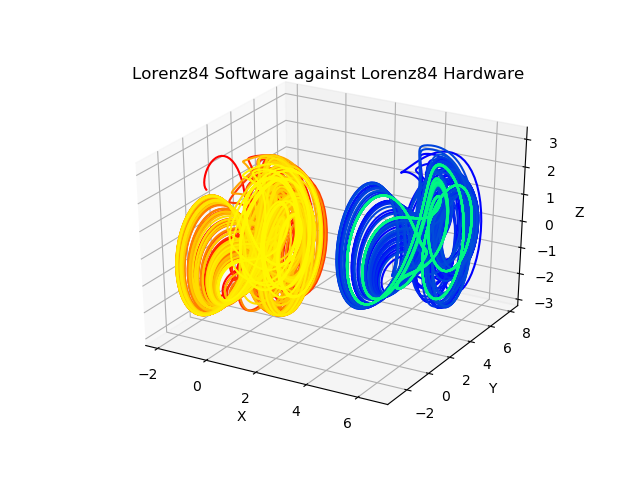

The average difference between software and hardware coordinates = 2.626338184729221


In [13]:
start = time.time()

valDifferenceTotal = 0

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xDiff=[]
xDiff = [0 for i in range(iterationNew)]

yDiff=[]
yDiff = [0 for i in range(iterationNew)]

zDiff=[]
zDiff = [0 for i in range(iterationNew)]

for j in range(0,steps):
    colorSoft = plt.cm.autumn(j/steps)
    colorHard = plt.cm.winter(j/steps)
    for i in range(0,iterationNew):
        if j!=0 and i == 0:     #So new set of points start at last and not the one after leaving gaps in the plot
            plotXHard[i] = xvalshw[j*iterationNew + i-1]+4.5
            plotYHard[i] = yvalshw[j*iterationNew + i-1]+4.5
            plotZHard[i] = zvalshw[j*iterationNew + i-1]
            
            plotXSoft[i] = x[j*iterationNew + i-1]
            plotYSoft[i] = y[j*iterationNew + i-1]
            plotZSoft[i] = z[j*iterationNew + i-1]
        else:    
            plotXHard[i] = xvalshw[j*iterationNew + i]+4.5
            plotYHard[i] = yvalshw[j*iterationNew + i]+4.5
            plotZHard[i] = zvalshw[j*iterationNew + i]
            
            plotXSoft[i] = x[j*iterationNew + i]
            plotYSoft[i] = y[j*iterationNew + i]
            plotZSoft[i] = z[j*iterationNew + i]
            
        valDifferenceTotal = valDifferenceTotal + abs((plotXHard[i] + plotYHard[i] + plotZHard[i] - 9) - 
                                                      (plotXSoft[i] + plotYSoft[i] + plotZSoft[i])) 
            
    ax.plot3D(plotXHard, plotYHard, plotZHard, color=colorHard)
    ax.plot3D(plotXSoft, plotYSoft, plotZSoft, color=colorSoft)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz84 Software against Lorenz84 Hardware')
plt.show()

averageDifference = valDifferenceTotal / (iterations+1)
print("The average difference between software and hardware coordinates =", averageDifference)

###### Comparing Implementation:

It is clear that the graphs of both the software and hardware implementation are nearly identical. The differences between the two implementations is down to the precision, where the software implementation uses a floating point system whereas the hardware implementation uses a fixde point system with truncation

##### Time Comparison:

In [14]:
print("Software duration =", elapsed_software_time, "seconds")
print("Hardware duration =", elapsed_hardware_time, "seconds")
print("The hardware implementation is", elapsed_software_time/elapsed_hardware_time, "times the speed of the software implementation")

Software duration = 3.872363805770874 seconds
Hardware duration = 5.000933647155762 seconds
The hardware implementation is 0.7743281712952236 times the speed of the software implementation
